<a href="https://colab.research.google.com/github/Akshatahadambar/Rain-Prediction/blob/main/DL_Rain_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from tensorflow.keras import callbacks

In [6]:
data = pd.read_csv("weatherAUS.csv")

In [7]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85988 entries, 0 to 85987
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           85988 non-null  object 
 1   Location       85988 non-null  object 
 2   MinTemp        84794 non-null  float64
 3   MaxTemp        84982 non-null  float64
 4   Rainfall       83658 non-null  float64
 5   Evaporation    46334 non-null  float64
 6   Sunshine       39411 non-null  float64
 7   WindGustDir    79721 non-null  object 
 8   WindGustSpeed  79729 non-null  float64
 9   WindDir9am     78224 non-null  object 
 10  WindDir3pm     83028 non-null  object 
 11  WindSpeed9am   84540 non-null  float64
 12  WindSpeed3pm   83921 non-null  float64
 13  Humidity9am    83924 non-null  float64
 14  Humidity3pm    83506 non-null  float64
 15  Pressure9am    75332 non-null  float64
 16  Pressure3pm    75379 non-null  float64
 17  Cloud9am       52511 non-null  float64
 18  Cloud3

In [10]:
# DATA VISUALIZATION AND CLEANING

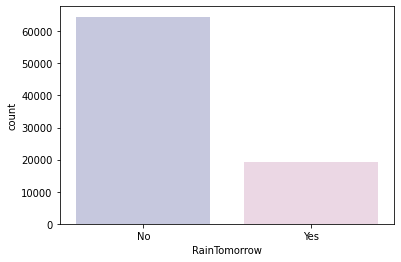

In [11]:
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

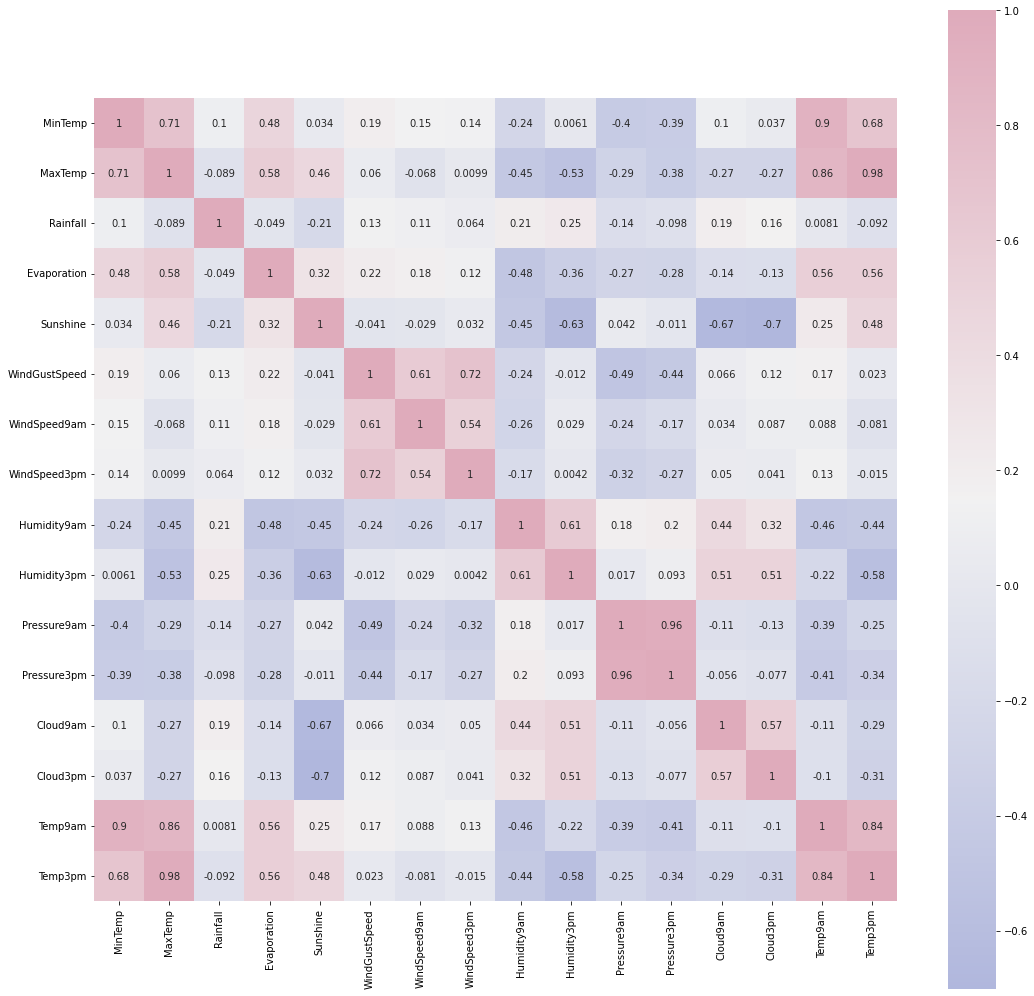

In [12]:
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [13]:
lengths = data["Date"].str.len()
lengths.value_counts()

10    85988
Name: Date, dtype: int64

In [14]:
data['Date']= pd.to_datetime(data["Date"])
data['year'] = data.Date.dt.year

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-01-12,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,2008,1,0.500000,8.660254e-01,12,0.651372,-0.758758
1,2008-02-12,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2008,2,0.866025,5.000000e-01,12,0.651372,-0.758758
2,2008-03-12,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,2008,3,1.000000,6.123234e-17,12,0.651372,-0.758758
3,2008-04-12,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,2008,4,0.866025,-5.000000e-01,12,0.651372,-0.758758
4,2008-05-12,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,2008,5,0.500000,-8.660254e-01,12,0.651372,-0.758758


Text(0.5, 0, 'Days In Year')

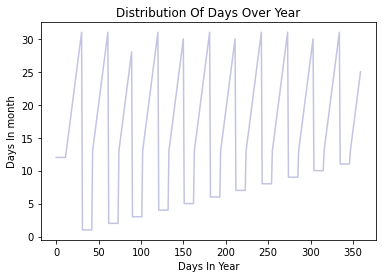

In [15]:
section = data[:360] 
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

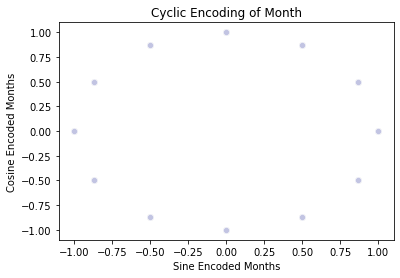

In [16]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

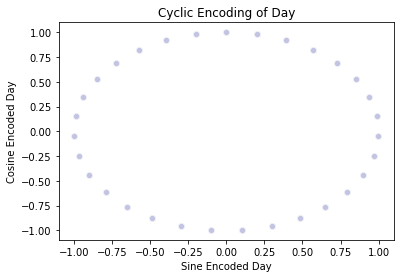

In [17]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [18]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [19]:
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 6267
WindDir9am 7764
WindDir3pm 2960
RainToday 2331
RainTomorrow 2329


In [20]:
for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [21]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [22]:
for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1194
MaxTemp 1006
Rainfall 2330
Evaporation 39654
Sunshine 46577
WindGustSpeed 6259
WindSpeed9am 1448
WindSpeed3pm 2067
Humidity9am 2064
Humidity3pm 2482
Pressure9am 10656
Pressure3pm 10609
Cloud9am 33477
Cloud3pm 34502
Temp9am 1561
Temp3pm 2036
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [23]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85988 entries, 0 to 85987
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           85988 non-null  datetime64[ns]
 1   Location       85988 non-null  object        
 2   MinTemp        85988 non-null  float64       
 3   MaxTemp        85988 non-null  float64       
 4   Rainfall       85988 non-null  float64       
 5   Evaporation    85988 non-null  float64       
 6   Sunshine       85988 non-null  float64       
 7   WindGustDir    85988 non-null  object        
 8   WindGustSpeed  85988 non-null  float64       
 9   WindDir9am     85988 non-null  object        
 10  WindDir3pm     85988 non-null  object        
 11  WindSpeed9am   85988 non-null  float64       
 12  WindSpeed3pm   85988 non-null  float64       
 13  Humidity9am    85988 non-null  float64       
 14  Humidity3pm    85988 non-null  float64       
 15  Pressure9am    8598

In [36]:
# Data Preprocessing 
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85988 entries, 0 to 85987
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           85988 non-null  datetime64[ns]
 1   Location       85988 non-null  int64         
 2   MinTemp        85988 non-null  float64       
 3   MaxTemp        85988 non-null  float64       
 4   Rainfall       85988 non-null  float64       
 5   Evaporation    85988 non-null  float64       
 6   Sunshine       85988 non-null  float64       
 7   WindGustDir    85988 non-null  int64         
 8   WindGustSpeed  85988 non-null  float64       
 9   WindDir9am     85988 non-null  int64         
 10  WindDir3pm     85988 non-null  int64         
 11  WindSpeed9am   85988 non-null  float64       
 12  WindSpeed3pm   85988 non-null  float64       
 13  Humidity9am    85988 non-null  float64       
 14  Humidity3pm    85988 non-null  float64       
 15  Pressure9am    8598

In [26]:
features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,85988.0,1.186316e-14,1.000006,-1.672716,-0.840803,-0.008890,0.823024,1.654937
MinTemp,85988.0,5.517884e-15,1.000006,-3.250228,-0.711357,-0.002451,0.755913,3.410187
MaxTemp,85988.0,1.352807e-15,1.000006,-3.924966,-0.701924,-0.074817,0.639794,3.673245
Rainfall,85988.0,-1.605960e-14,1.000006,-0.285281,-0.285281,-0.285281,-0.210798,45.769716
Evaporation,85988.0,-2.905192e-14,1.000006,-1.578979,-0.218084,-0.150039,-0.081995,47.753444
Sunshine,85988.0,-3.240944e-14,1.000006,-2.874621,0.122422,0.122422,0.122422,2.626281
WindGustDir,85988.0,2.359941e-17,1.000006,-1.776740,-0.922137,0.146118,1.000721,1.428023
WindGustSpeed,85988.0,-1.046222e-14,1.000006,-2.362756,-0.699487,-0.193275,0.457570,6.893697
WindDir9am,85988.0,3.677964e-15,1.000006,-1.609766,-0.955498,-0.083142,1.007304,1.661572
WindDir3pm,85988.0,1.698842e-15,1.000006,-1.734186,-0.844595,0.044995,0.934586,1.601779


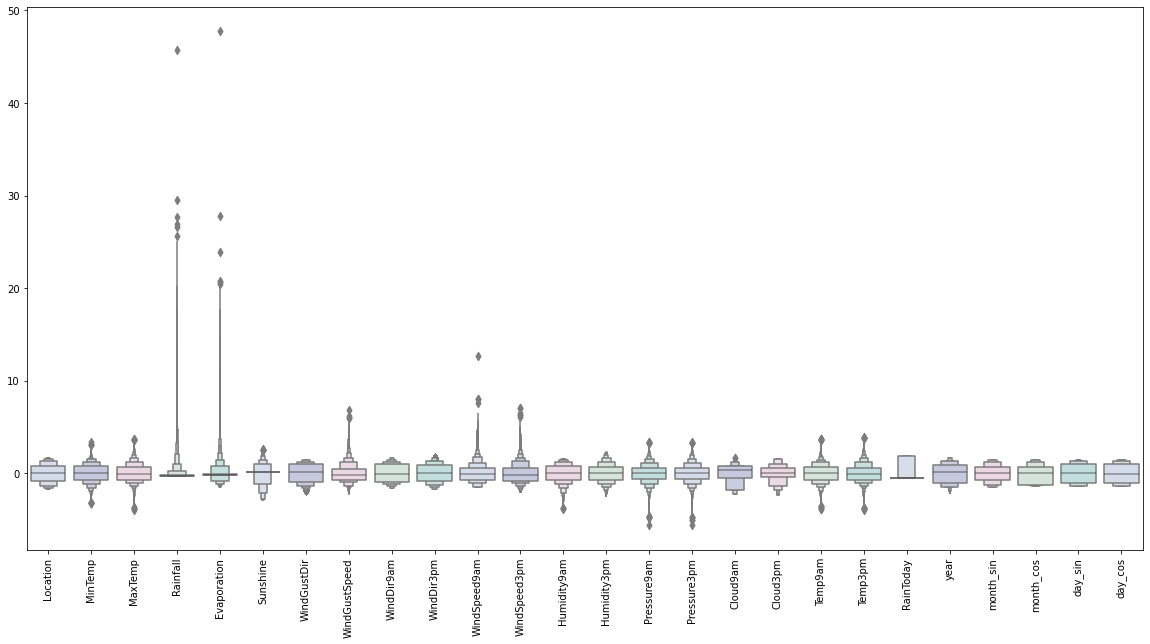

In [27]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()


In [28]:
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]

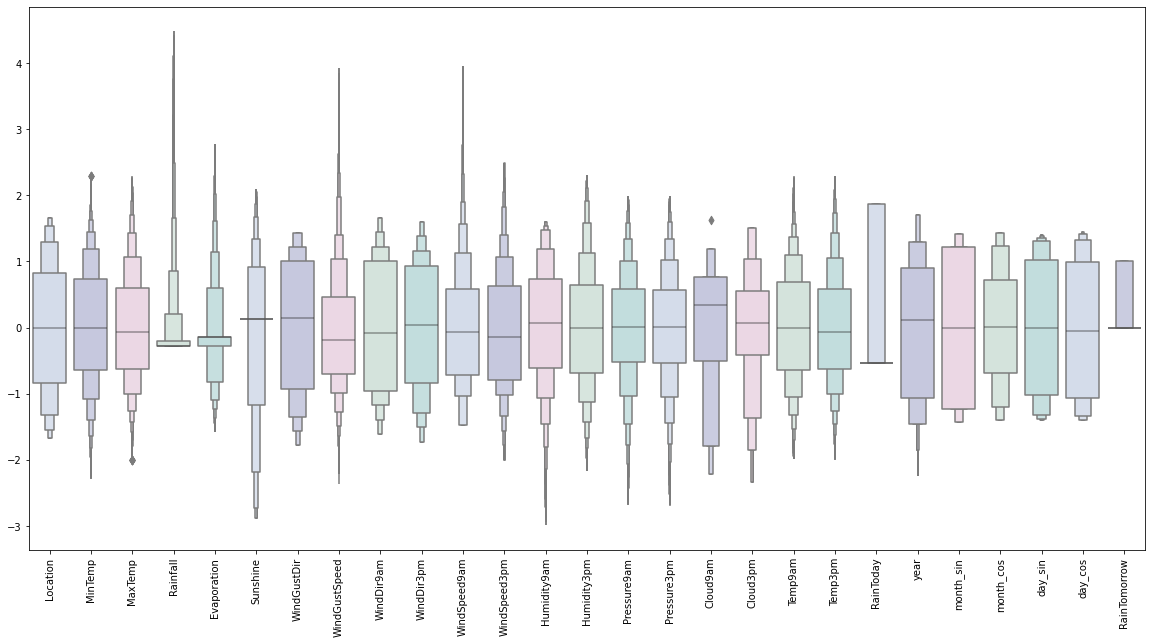

In [29]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()


In [37]:
# Model
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(74084, 26)

In [31]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1482/1482 [==============================] - 5s 3ms/step - loss: 0.5177 - accuracy: 0.7807 - val_loss: 0.4048 - val_accuracy: 0.7805
Epoch 2/150
1482/1482 [==============================] - 4s 2ms/step - loss: 0.4330 - accuracy: 0.7823 - val_loss: 0.3944 - val_accuracy: 0.7805
Epoch 3/150
1482/1482 [==============================] - 4s 2ms/step - loss: 0.4253 - accuracy: 0.8044 - val_loss: 0.3887 - val_accuracy: 0.8408
Epoch 4/150
1482/1482 [==============================] - 4s 3ms/step - loss: 0.4201 - accuracy: 0.8093 - val_loss: 0.3840 - val_accuracy: 0.8428
Epoch 5/150
1482/1482 [==============================] - 4s 2ms/step - loss: 0.4153 - accuracy: 0.8079 - val_loss: 0.3793 - val_accuracy: 0.8430
Epoch 6/150
1482/1482 [==============================] - 4s 3ms/step - loss: 0.4130 - accuracy: 0.8084 - val_loss: 0.3761 - val_accuracy: 0.8433
Epoch 7/150
1482/1482 [==============================] - 4s 3ms/step - loss: 0.4108 - accuracy: 0.8099 - val_loss: 0.3742 - val_ac

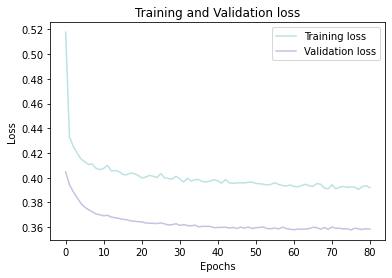

In [32]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

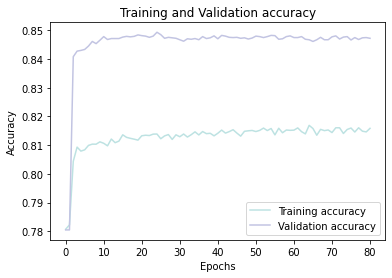

In [33]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

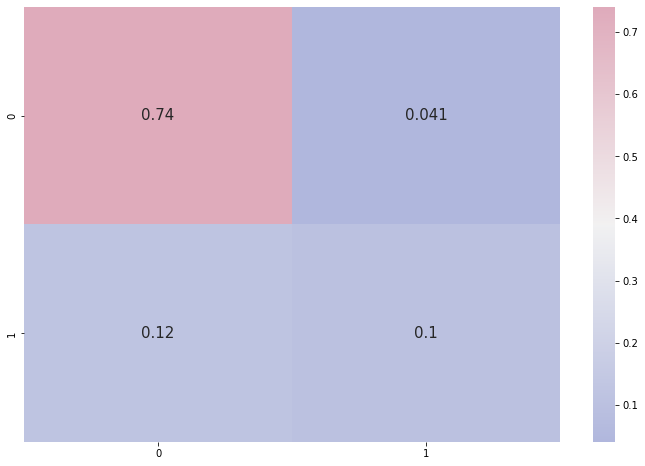

In [35]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})


In [38]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11572
           1       0.71      0.46      0.56      3245

    accuracy                           0.84     14817
   macro avg       0.79      0.71      0.73     14817
weighted avg       0.83      0.84      0.83     14817

